In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import shap
import os
import joblib
from pathlib import Path

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
shap_df = pd.read_csv('../../data/processed_data/riders_trips_rfms_churned.csv')
shap_df.drop(columns=['active_days', 'RFMS_weighted_score', 'total_spend', 'avg_surge'], inplace=True)
shap_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  object 
 1   recency           10000 non-null  int64  
 2   total_trips       10000 non-null  int64  
 3   avg_spend         10000 non-null  float64
 4   total_tip         10000 non-null  float64
 5   avg_tip           10000 non-null  float64
 6   avg_rating_given  10000 non-null  float64
 7   loyalty_status    10000 non-null  object 
 8   city              10000 non-null  object 
 9   avg_distance      10000 non-null  float64
 10  avg_duration      10000 non-null  float64
 11  RFMS_segment      10000 non-null  object 
 12  churned           10000 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 1015.8+ KB


### Define preprocessing pipelines

In [3]:
numeric_features = shap_df.select_dtypes(include='number').columns.tolist()
nominal_categorical_features = ['city']
ordinal_categorical_features = ['loyalty_status', 'RFMS_segment']

ordinal_categories = [
    ['Bronze', 'Silver', 'Gold', 'Platinum'],  # loyalty_status
    ['At Risk', 'Occasional Riders', 'Core Loyal Riders', 'High-Value Surge-Tolerant']  # RFMS_segment
]

#### Scaling not needed for RF models
# Numeric preprocessing
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler())
])

# Categorical preprocessing
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


ordinal_transformer = Pipeline(steps=[
    ("ordinal_encoder", OrdinalEncoder(categories=ordinal_categories, handle_unknown="use_encoded_value", unknown_value=-1))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # ("num", numeric_transformer, numeric_features),
        ("ord", ordinal_transformer, ordinal_categorical_features),
        ("cat", categorical_transformer, nominal_categorical_features)
    ]
)

In [4]:
### Save preprocessor

In [5]:
# # Define model directory
# BASE_DIR = "../../"
# os.makedirs(BASE_DIR + 'output/model', exist_ok=True)

# # File paths
# PREPROCESSOR_PATH = os.path.join(BASE_DIR + "output/model/preprocessor.joblib")

# # Save the trained model
# joblib.dump(preprocessor, PREPROCESSOR_PATH)

['../../output/model/preprocessor.joblib']

In [6]:
X = shap_df.drop(columns=['churned', 'user_id'])
y = shap_df['churned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)

In [7]:
# Fit SMOTE separately
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_transformed, y_train)

#### Load SHAP for Random Forest Model

In [8]:
# File paths
BASE_DIR = "../../"
MODEL_PATH = os.path.join(BASE_DIR + "output/model/rfm_churn_model.joblib")
METADATA_PATH = os.path.join(BASE_DIR + "output/model/rfm_churn_model_metadata.joblib")

# Load model
rf_model = joblib.load(MODEL_PATH)
# Load metadata
metadata = joblib.load(METADATA_PATH)

# Fit Model
rf_model.fit(X_res, y_res)

RandomForestClassifier(random_state=42)

In [9]:
# Background
X_background = X_train.sample(200, random_state=42)
X_background_transformed = preprocessor.transform(X_background)

# Test sample
X_test_sample = X_test.sample(300, random_state=42)
# Transform test data
X_test_transformed = preprocessor.transform(X_test_sample)

# Feature names
feature_names = preprocessor.get_feature_names_out()

X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Explainer
explainer = shap.TreeExplainer(
    rf_model,
    data=pd.DataFrame(
        X_background_transformed, 
        columns=preprocessor.get_feature_names_out()
    ),
    feature_perturbation="interventional",
    check_additivity=False
)

shap_values = explainer.shap_values(X_test_transformed_df)
# shap_values = explainer.shap_values(X_test_transformed)

# Logistic Model
# explainer = shap.LinearExplainer(
#     rf_model.named_steps["model"],
#     rf_model.named_steps["preprocessor"].transform(X_background),
#     feature_names=all_features
# )

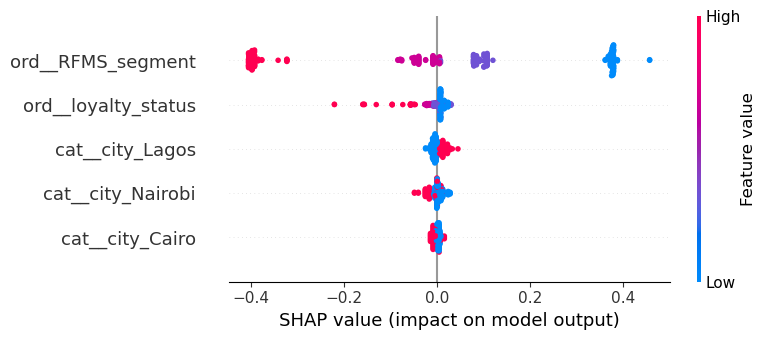

In [10]:
shap.summary_plot(
    shap_values[1],
    X_test_transformed_df,
)

In [11]:
# Define model directory
# for notebooks
BASE_DIR = Path.cwd().parents[1]

# for FastAPI
# BASE_DIR = Path(__file__).resolve().parents[2]
MODEL_DIR = BASE_DIR / "output" / "model"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PIPELINE_PATH = MODEL_DIR / "rfm_churn_model_pipeline.joblib"

rfm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", rf_model),  
])

joblib.dump(rfm_pipeline, MODEL_PIPELINE_PATH)

['C:\\Users\\godfr\\Documents\\Amdari\\Project 4 - Final\\output\\model\\rfm_churn_model_pipeline.joblib']